IMPORTS

In [24]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix



PROCESSING DATA AND TOKENIZATION

In [25]:

nltk.download('stopwords')
nltk.download('punkt')

# Definir una función para preprocesar el texto
def preprocess_text(text):
    # Convertir el texto a minúsculas
    text = text.lower()
    
    # Eliminar caracteres especiales y números usando expresiones regulares
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Tokenizar el texto en palabras
    words = word_tokenize(text)
    
    # Eliminar stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    
    # Unir las palabras preprocesadas en un solo string
    preprocessed_text = ' '.join(words)
    
    return preprocessed_text



[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ezequielgarcia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/ezequielgarcia/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


LOADING DATA AND SPLITING

In [26]:

# Cargar el archivo CSV en un DataFrame
df = pd.read_csv('spam_ham_dataset.csv')


# Definir las características (X) y las etiquetas (y)
X = df['text']  # Características
y = df['label_num']  # Etiquetas


X = X.apply(preprocess_text)



# Dividir los datos en conjuntos de entrenamiento, validación y prueba
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

# Inicializar el vectorizador TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=2500)  # Puedes ajustar max_features según lo que consideres adecuado

# Ajustar y transformar el conjunto de entrenamiento
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Transformar el conjunto de validación
X_val_tfidf = tfidf_vectorizer.transform(X_val)

# Transformar el conjunto de prueba
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Convertir las matrices dispersas a matrices densas
X_train_tfidf = X_train_tfidf.toarray()
X_val_tfidf = X_val_tfidf.toarray()
X_test_tfidf = X_test_tfidf.toarray()

NETWORK

In [27]:

# Definir el modelo de la red neuronal
model = Sequential()
model.add(Dense(500, input_shape=(X_train_tfidf.shape[1],), activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])



/home/ezequielgarcia/.local/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


TRAINING

In [28]:
# Entrenar el modelo
history = model.fit(X_train_tfidf, y_train, epochs=25, batch_size=1500, validation_data=(X_val_tfidf, y_val))

Epoch 1/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 249ms/step - accuracy: 0.4770 - loss: 0.6922 - val_accuracy: 0.7253 - val_loss: 0.6708
Epoch 2/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step - accuracy: 0.7102 - loss: 0.6629 - val_accuracy: 0.7273 - val_loss: 0.6180
Epoch 3/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step - accuracy: 0.7113 - loss: 0.6034 - val_accuracy: 0.7369 - val_loss: 0.5225
Epoch 4/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step - accuracy: 0.7252 - loss: 0.4997 - val_accuracy: 0.7872 - val_loss: 0.3908
Epoch 5/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.8110 - loss: 0.3618 - val_accuracy: 0.8859 - val_loss: 0.2728
Epoch 6/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step - accuracy: 0.9105 - loss: 0.2504 - val_accuracy: 0.9497 - val_loss: 0.1956
Epoch 7/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9678 - loss: 0.1629 - val_accuracy: 0.9516 - val_loss: 0.1477
Epoch 8/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step - accuracy: 0.9863 - loss: 0.0992 - val_accuracy: 0.9574 - val_loss:

CONFUSION MATRIX WITH THE SAME DATASET THAT WAS TRAINED WITH (TEST DATA) || This matrix detects the cases where the labels (results) were successful or not and what happened with each particular data

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


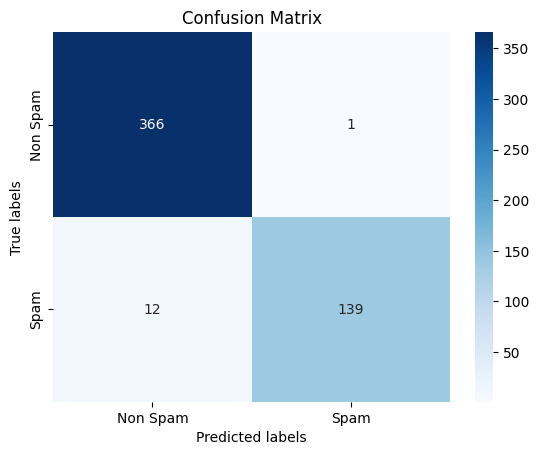

In [29]:


# Predecir en el conjunto de datos de prueba
y_pred_prob = model.predict(X_test_tfidf)
y_pred = (y_pred_prob > 0.5).astype("int32")  # Convertir las probabilidades en clases binarias (0 o 1)

# Generar la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualizar la matriz de confusión
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non Spam', 'Spam'], yticklabels=['Non Spam', 'Spam'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


LOSS AND ACCURACY

In [30]:
# Evaluación del modelo
loss, accuracy = model.evaluate(X_test_tfidf, y_test)
print("Loss on test set:", loss)
print("Accuracy on test set:", accuracy)


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9829 - loss: 0.0831
Loss on test set: 0.1713264435529709
Accuracy on test set: 0.9749034643173218


GRAPH TO VISUALIZE OVERFITTING AND GENERAL DETAILS

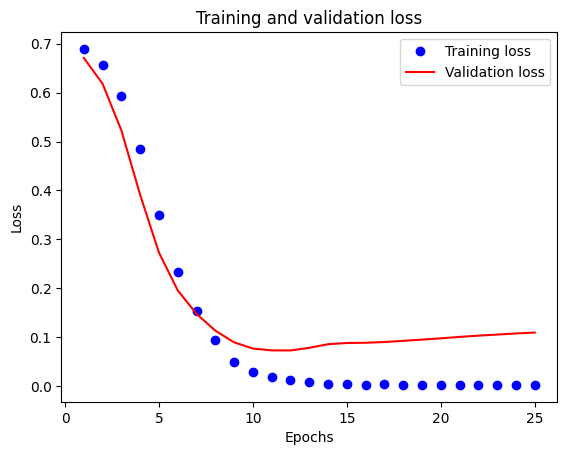

In [31]:
# overfitting: 

def plot_loss(train_loss, val_loss):
    epochs = range(1, len(train_loss) + 1)
    plt.plot(epochs, train_loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()



train_loss = history.history['loss']
val_loss = history.history['val_loss']

plot_loss(train_loss, val_loss)


TESTING AND CONFUSION MATRIX WITH A SECOND DATASET || This matrix detects the cases where the labels (results) were successful or not and what happened with each particular data

179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


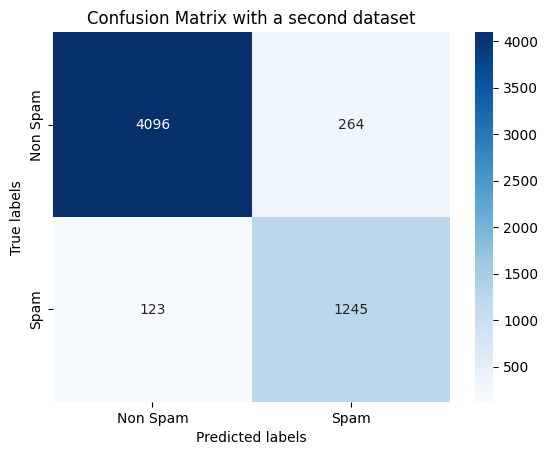

In [35]:

# Load data
data = pd.read_csv('emails.csv')

X = data['text']
Y = data['spam']

X = X.apply(preprocess_text)





# Transformar el conjunto de prueba
X_test_tfidf_2 = tfidf_vectorizer.transform(X)

# Convertir las matrices dispersas a matrices densas
X_test_tfidf_2 = X_test_tfidf_2.toarray()


# Predecir en el conjunto de datos de prueba
y_pred_prob = model.predict(X_test_tfidf_2)
y_pred = (y_pred_prob > 0.5).astype("int32")  # Convertir las probabilidades en clases binarias (0 o 1)

# Generar la matriz de confusión
conf_matrix = confusion_matrix(Y, y_pred)

# Visualizar la matriz de confusión
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non Spam', 'Spam'], yticklabels=['Non Spam', 'Spam'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix with a second dataset')
plt.show()




ACCURACY ON THAT SECOND DATASET

In [34]:
accuracy = (conf_matrix[0, 0] + conf_matrix[1, 1]) / conf_matrix.sum()
print("Accuracy:", accuracy)


Accuracy: 0.9324371508379888


93% ACCURACY ON A SECOND DATASET!